In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from torch import nn
from IPython import display
from matplotlib import pyplot as plt

from d2l import torch as d2l

In [2]:
def use_svg_display():
    """使用svg格式在Jupyter中显示绘图

    Defined in :numref:`sec_calculus`"""
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """设置matplotlib的图表大小

    Defined in :numref:`sec_calculus`"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点

    Defined in :numref:`sec_calculus`"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

In [3]:
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [4]:
class Timer:  #@save
    """记录多次运行时间。"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器。"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中。"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间。"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和。"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间。"""
        return np.array(self.times).cumsum().tolist()

In [5]:
ones = torch.ones
zeros = torch.zeros
tensor = torch.tensor
arange = torch.arange
meshgrid = torch.meshgrid
sin = torch.sin
sinh = torch.sinh
cos = torch.cos
cosh = torch.cosh
tanh = torch.tanh
linspace = torch.linspace
exp = torch.exp
log = torch.log
normal = torch.normal
rand = torch.rand
randn = torch.randn
matmul = torch.matmul
int32 = torch.int32
float32 = torch.float32
concat = torch.cat
stack = torch.stack
abs = torch.abs
eye = torch.eye
numpy = lambda x, *args, **kwargs: x.detach().numpy(*args, **kwargs)
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
reshape = lambda x, *args, **kwargs: x.reshape(*args, **kwargs)
to = lambda x, *args, **kwargs: x.to(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
transpose = lambda x, *args, **kwargs: x.t(*args, **kwargs)
reduce_mean = lambda x, *args, **kwargs: x.mean(*args, **kwargs)

In [6]:
timer = Timer()
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

In [7]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

#@save
def get_data(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

In [8]:
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [9]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失

    Defined in :numref:`sec_model_selection`"""
    metric = Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = reshape(y, out.shape)
        l = loss(out, y)
        metric.add(reduce_sum(l), size(l))
    return metric[0] / metric[1]

# Customize a optimizer examples

In [10]:
def linreg(X, w, b):
    """线性回归模型

    Defined in :numref:`sec_linear_scratch`"""
    return torch.mm(X, w) + b

def squared_loss(y_hat, y):
    """均方损失

    Defined in :numref:`sec_linear_scratch`"""
    return (y_hat - torch.reshape(y, y_hat.shape)) ** 2 / 2

In [11]:
def train_customize_optimizer(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    """Defined in :numref:`sec_minibatches`"""
    # 初始化模型
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: linreg(X, w, b), squared_loss
    # 训练模型
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

loss: 0.244, 0.005 sec/epoch


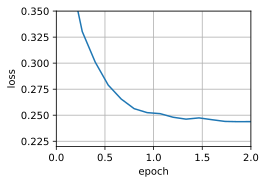

In [12]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()
        
data_iter, feature_dim = get_data(batch_size=10)
train_customize_optimizer(sgd, None, {'lr': 0.02}, data_iter, feature_dim);

loss: 0.251, 0.005 sec/epoch


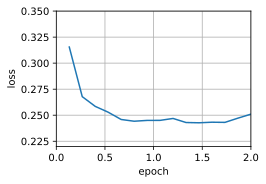

In [13]:
def init_momentum_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()
        
data_iter, feature_dim = get_data(batch_size=10)
train_customize_optimizer(sgd_momentum, init_momentum_states(feature_dim),
                   {'lr': 0.02, 'momentum': 0.5}, data_iter,feature_dim);

loss: 0.243, 0.005 sec/epoch


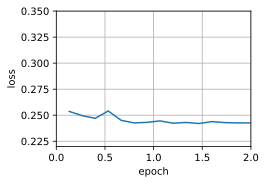

In [14]:
def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()
        
data_iter, feature_dim = get_data(batch_size=10)
train_customize_optimizer(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim);

loss: 0.244, 0.005 sec/epoch


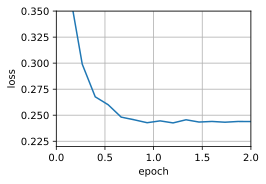

In [15]:
def init_rmsprop_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()
data_iter, feature_dim = get_data(batch_size=10)
train_customize_optimizer(rmsprop, init_rmsprop_states(feature_dim),
               {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim);

loss: 0.244, 0.006 sec/epoch


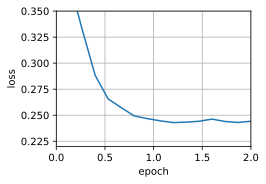

In [16]:
def init_adadelta_states(feature_dim):
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    delta_w, delta_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            # In-placeupdatesvia[:]
            s[:] = rho * s + (1 - rho) * torch.square(p.grad)
            g = (torch.sqrt(delta + eps) / torch.sqrt(s + eps)) * p.grad
            p[:] -= g
            delta[:] = rho * delta + (1 - rho) * g * g
        p.grad.data.zero_()
data_iter, feature_dim = get_data(batch_size=10)
train_customize_optimizer(adadelta, init_adadelta_states(feature_dim),
               {'rho': 0.9}, data_iter, feature_dim);

In [17]:
def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

loss: 0.244, 0.007 sec/epoch


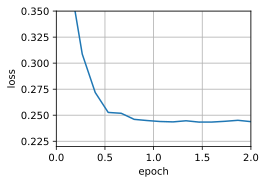

In [18]:
def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1
    
data_iter, feature_dim = get_data(batch_size=10)
train_customize_optimizer(adam, init_adam_states(feature_dim),
                          {'lr': 0.01, 't': 1}, data_iter, feature_dim);

## Yogi

Adam算法也存在一些问题：
即使在凸环境下，当$\mathbf{s}_t$的第二力矩估计值爆炸时，它可能无法收敛。
 :cite:`Zaheer.Reddi.Sachan.ea.2018`为$\mathbf{s}_t$提出了的改进更新和参数初始化。
论文中建议我们重写Adam算法更新如下：

$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \left(\mathbf{g}_t^2 - \mathbf{s}_{t-1}\right).$$

每当$\mathbf{g}_t^2$具有高变量或更新稀疏时，$\mathbf{s}_t$可能会太快地“忘记”过去的值。
一个有效的解决方法是将$\mathbf{g}_t^2 - \mathbf{s}_{t-1}$替换为$\mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1})$。
这就是Yogi更新，现在更新的规模不再取决于偏差的量。

$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1}).$$

论文中，作者还进一步建议用更大的初始批量来初始化动量，而不仅仅是初始的逐点估计。

loss: 0.243, 0.007 sec/epoch


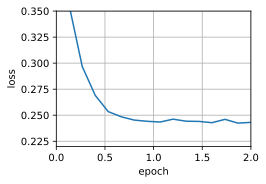

In [19]:
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-3
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = s + (1 - beta2) * torch.sign(
                torch.square(p.grad) - s) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

data_iter, feature_dim = get_data(batch_size=10)
train_customize_optimizer(yogi, init_adam_states(feature_dim),
                          {'lr': 0.01, 't': 1}, data_iter, feature_dim);